In [1]:
import torch
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math, random, torch, collections, time, torch.nn.functional as F, networkx as nx, matplotlib.pyplot as plt, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:

# Helper function for visualization.
%matplotlib inline
import sys,os
sys.path.append('../')

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import torch_geometric as tg
import pandas as pd
from data_utils import *
dataset_name = 'Cora'
dataset = Planetoid(root='Planetoid', name=dataset_name, transform=NormalizeFeatures())
data = dataset[0]
dataset_print(dataset)
data_print(data)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


/Users/cdonnat/anaconda3/envs/myenv/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/Users/cdonnat/anaconda3/envs/myenv/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


In [3]:
from numbers import Number
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, APPNP
class GCNter(nn.Module): # in_dim, hid_dims, out_dim, normalize=True
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, end='linear',
    activation='relu', slope=.1, device='cpu', normalize=True):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.end = end
        self.n_layers = n_layers
        self.device = device
        self.propagate = APPNP(K=1, alpha=0)
        self.normalize = normalize
        
        if isinstance(hidden_dim, Number):
            self.hidden_dim = [hidden_dim] * (self.n_layers - 1)
        elif isinstance(hidden_dim, list):
            self.hidden_dim = hidden_dim
        else:
            raise ValueError('Wrong argument type for hidden_dim: {}'.format(hidden_dim))

        if isinstance(activation, str):
            self.activation = [activation] * (self.n_layers - 1)
        elif isinstance(activation, list):
            self.hidden_dim = activation
        else:
            raise ValueError('Wrong argument type for activation: {}'.format(activation))

        self._act_f = []
        for act in self.activation:
            if act == 'lrelu':
                self._act_f.append(lambda x: F.leaky_relu(x, negative_slope=slope))
            elif act == 'relu':
                self._act_f.append(lambda x: torch.nn.ReLU()(x))
            elif act == 'xtanh':
                self._act_f.append(lambda x: self.xtanh(x, alpha=slope))
            elif act == 'sigmoid':
                self._act_f.append(F.sigmoid)
            elif act == 'none':
                self._act_f.append(lambda x: x)
            else:
                ValueError('Incorrect activation: {}'.format(act))

        if self.n_layers == 1:
            _fc_list = [nn.Linear(self.input_dim, self.output_dim)]
        else:
            _fc_list = [nn.Linear(self.input_dim, self.hidden_dim[0])]
            for i in range(1, self.n_layers - 1):
                _fc_list.append(nn.Linear(self.hidden_dim[i - 1], self.hidden_dim[i]))
            _fc_list.append(nn.Linear(self.hidden_dim[self.n_layers - 2], self.output_dim))
        self.fc = nn.ModuleList(_fc_list)
        self.to(self.device)

    @staticmethod
    def xtanh(x, alpha=.1):
        """tanh function plus an additional linear term"""
        return x.tanh() + alpha * x

    def forward(self, x, edge_index):
        h = x
        for c in range(self.n_layers):
            if c == self.n_layers - 1:
                if self.end == 'linear': 
                    h = self.fc[c](h)
                else:
                    h = self.propagate(h, edge_index)
            else:
                h = self.fc[c](h)
                h = F.dropout(h, p=0.5, training=self.training)
                h = self.propagate(h, edge_index)
                if self.normalize: h = F.normalize(h, p=2, dim=1)
                h = self._act_f[c](h)
        return h

model = GCNter(data.num_features, 32, 32, n_layers=2, end='propagate',
                                normalize=True)

In [4]:
import numpy as np


def prob_high_dim(sigma, dist):
    """
    For each row of Euclidean distance matrix (dist_row) compute
    probability in high dimensions (1D array)
    """
    d = dist - np.min(dist); d[d < 0] = 0
    return np.exp(- d / sigma)

def k(prob):
    """
    Compute n_neighbor = k (scalar) for each 1D array of high-dimensional probability
    """
    return np.power(2, np.sum(prob))


def sigma_binary_search(k_of_sigma, fixed_k):
    """
    Solve equation k_of_sigma(sigma) = fixed_k
    with respect to sigma by the binary search algorithm
    Do we really need this?
    """
    sigma_lower_limit = 0;
    sigma_upper_limit = 100;
    for i in range(20):
        approx_sigma = (sigma_lower_limit + sigma_upper_limit) / 2
        if k_of_sigma(approx_sigma) < fixed_k:
            sigma_lower_limit = approx_sigma
        else:
            sigma_upper_limit = approx_sigma
        if np.abs(fixed_k - k_of_sigma(approx_sigma)) <= 1e-5:
            break
    return approx_sigma


def prob_low_dim(Y, YY, a=1., b=1.):
    """
    Compute matrix of probabilities q_ij in low-dimensional space
    """
    inv_distances = torch.power(1 + a * torch.sum(torch.square(Y-YY))**b, -1)
    return inv_distances


(array([53595.,  5495.,  3327.,  2410.,  2067.,  1541.,  1333.,  1107.,
          889.,  9476.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

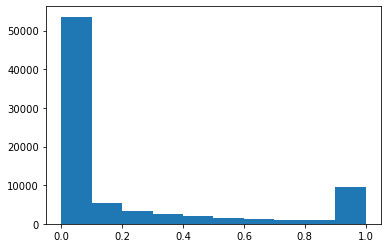

In [5]:
#### Compute the edge weights
import torch_geometric.transforms as T
from torch_geometric.utils import to_scipy_sparse_matrix, to_networkx
import copy
from umap import *
data = dataset[0]  # Get the first graph object.
data.edge_weight = torch.ones(data.edge_index.shape[1])
transform = T.GDC(
        self_loop_weight=1.,
        normalization_in='row',
        normalization_out='row',
        diffusion_kwargs=dict(method='ppr', alpha=0.2),
        sparsification_kwargs=dict(method='topk', k=30, dim=0),
        exact=True,
    )

data2 = transform(copy.deepcopy(data))

newA = to_scipy_sparse_matrix(data2.edge_index, data2.edge_attr) 
rows = []
cols = []
weights = []
sigmas = []
n_eff_neighbours = []
N_NEIGHBOURS = 20
for u in range(data.num_nodes):
    rows+= list(newA.row[newA.row == u])
    cols+= list(newA.col[newA.row == u])
    #### want to find the appropriate scaling factor
    dist_row = newA.data[newA.row == u]
    func = lambda sigma: k(prob_high_dim(sigma, dist_row))
    binary_search_result = sigma_binary_search(func, N_NEIGHBOURS) #### Maybe we should have a varying number of neighbours here
    sigmas += [binary_search_result]
    weights += list(prob_high_dim(binary_search_result, dist_row))
    n_eff_neighbours += [k(prob_high_dim(binary_search_result, dist_row))]
plt.hist(weights)

(array([1.351e+03, 1.310e+03, 9.000e+00, 2.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  3.99088545,  19.99720257,  36.00351969,  52.0098368 ,
         68.01615392,  84.02247104, 100.02878816, 116.03510528,
        132.0414224 , 148.04773951, 164.05405663]),
 <BarContainer object of 10 artists>)

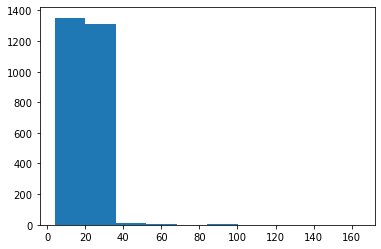

In [6]:
plt.hist(np.array(n_eff_neighbours)[np.array(n_eff_neighbours)<10**3])

In [7]:
binary_search_result 

0.000667572021484375

tensor([0.0603, 0.5436, 0.9392,  ..., 0.1783, 0.0000, 0.0000])


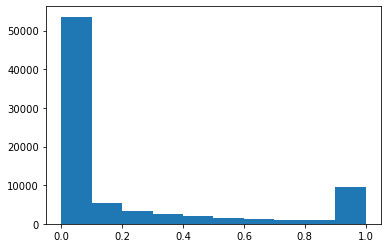

Hyperparameters a = 1.5295919329483947 and b = 0.8443373647932322
Epoch=000, loss=1.7103
=== Evaluation ===


<Figure size 432x288 with 0 Axes>

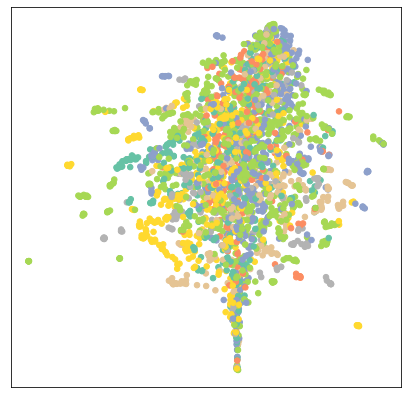

IndexError: list index out of range

In [28]:
model = GCNter(data.num_features, 512, 512, n_layers=2, end='prop',
                                normalize=True)
### we might not want to normalize.
### we might not want to use the dot product as a similarity matrix/
from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit

optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                                 weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()  

from sklearn.metrics import accuracy_score
from train_utils import *
from scipy import optimize
from torch_geometric.utils import remove_self_loops, negative_sampling, add_remaining_self_loops

from io_utils.visualisation import *
from carbontracker.tracker import CarbonTracker
from edge_prediction import edge_prediction
from node_prediction import node_prediction



training_rate = 0.85
MAX_EPOCH_EVAL = 100
#tracker = CarbonTracker(epochs=MAX_EPOCH_EVAL)
val_ratio = (1.0 - training_rate) / 3
test_ratio = (1.0 - training_rate) / 3 * 2
transform = RandomLinkSplit(num_val=val_ratio, num_test=test_ratio,
                                is_undirected=True, split_labels=True)
transform_nodes = RandomNodeSplit(split = 'test_rest',
                                      num_train_per_class = 20,
                                      num_val = 500)
train_data, val_data, test_data = transform(data)
rand_data = transform_nodes(data)
# MIN_DIST = 1e-1  Worked really well
MIN_DIST = 1.

add_self_loops=True
fill_value = 1
# alpha = 0.5

edge_index0 = data.edge_index
edge_weight = torch.ones((edge_index0.size(1), ))


# num_nodes = data.num_nodes
edge_index, edge_weight = add_remaining_self_loops(
                 edge_index0, edge_weight, fill_value, data.num_nodes)

row, col = edge_index[0], edge_index[1]
# deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
# deg_inv_sqrt = deg.pow_(-alpha)
# deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
# L = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
# #L = deg_inv_sqrt[row] * edge_weight #* deg_inv_sqrt[col]

# P = to_scipy_sparse_matrix(edge_index, edge_attr=L, num_nodes=data.num_nodes)
# A = P + P.T - P.multiply(P.T)
# d = from_scipy_sparse_matrix(A)#
#edge_weights  = d[1]#0.5 * (1 + d[1])
edge_index = torch.vstack([torch.from_numpy(np.array(rows)),
                          torch.from_numpy(np.array(cols))]).long()
edge_weights = torch.from_numpy(np.array(weights))
print(edge_weights )


plt.figure()
plt.hist(edge_weights.numpy())
plt.show()
MIN_DIST = 1e-1


x = np.linspace(0, 2, 300)

def f(x, min_dist):
    y = []
    for i in range(len(x)):
        if(x[i] <= min_dist):
            y.append(1)
        else:
            y.append(np.exp(- x[i] + min_dist))
    return y

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))
EPS = 1e-3


p , _ = optimize.curve_fit(dist_low_dim, x, f(x, MIN_DIST))
a = p[0]
b = p[1]
print("Hyperparameters a = " + str(a) + " and b = " + str(b))
lbda = 1e-2


for epoch in range(400):
    #tracker.epoch_start()
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)
    #edge
    #print("out", out)
    # pdb.set_trace()
    #### Evaluate on existing edges
    output_activation = torch.nn.Sigmoid()
    #logits = output_activation(torch.mm(logits_temp, logits_temp.t()))
    #edge = output_activation(torch.mm(logits_temp, logits_temp.t()))
    #### Look for min per node
    #min_dist = 
    ##### Subsample training edges
    #train_index = torch.randperm(data.edge_index.shape[1])[:5000]
    train_index = np.arange(data.edge_index.shape[1]) #dattorch.randperm(data.edge_index.shape[1])#[:1000]
    #train_indices = train_index[row[train_index]!=col[train_index]]
    (row_pos, col_pos), edge_weights_pos = remove_self_loops(edge_index, edge_weights)
    #d = torch.cdist(out[row[train_index]], out[col[train_index]], p=2.0)
    #d_min = torch.sort(d, 1)[0][:,1]
    #### subsample
    indices = torch.randperm(len(row_pos))[:data.edge_index.shape[1]]
    (row_pos, col_pos), edge_weights_pos = (row_pos[indices], col_pos[indices]), edge_weights_pos[indices]
    diff_norm = torch.sum(torch.square(out[row_pos] - out[col_pos]), 1) + EPS
    q =  torch.pow(1.  + a * torch.exp(b * torch.log(diff_norm)), -1)
    q = torch.clamp(q, EPS, 1.-EPS)  ### ensure above 0
    #### Maybe the as and the bs should be node dependent
    #print("q_pos",torch.max(q),  torch.min(q))
    #loss = criterion(q, L[val_indices])
    edge_weights_pos = (1-EPS) * torch.ones((len(row_pos), 1))
    #loss = torch.mean((1-EPS) * torch.ones((len(row_pos), 1)) * (torch.log((1-EPS) * torch.ones((len(row_pos), 1))) - torch.log(q)  ))  +\
    #      torch.mean((EPS) *(torch.ones((len(row_pos), 1))) * (torch.log((EPS) *(torch.ones((len(row_pos), 1)))) - torch.log(1.-q)  )) 
    #loss = torch.mean(q * (-torch.log(edge_weights_pos) + torch.log(q)  ))  + torch.mean((1.-q) * (-torch.log(1.-edge_weights_pos) + torch.log(1.-q)  )) 
    #### add loss 
    loss =  -torch.mean(edge_weights_pos *  torch.log(q)  )  - torch.mean((1.-edge_weights_pos) * (  torch.log(1.-q)  )) 
    #print("loss pos", loss)
    neg_edge_index = negative_sampling(data.edge_index, data.num_nodes, num_neg_samples=1000)
    row_neg, col_neg = neg_edge_index[0], neg_edge_index[1]
# #     loss += criterion(output_activation(torch.sum(out[neg_edge_index[0]] * out[neg_edge_index[1]], 1)), 
# #                       torch.zeros((neg_edge_index.shape[1])))
    diff_norm = torch.sum(torch.square(out[row_neg] - out[col_neg]), 1)+ EPS
    #diff_norm = torch.clamp(diff_norm, EPS, 1.-EPS)  ### ensure above 0
#     #print("diffnorm neg", torch.sum(torch.isnan(diff_norm)), torch.max(diff_norm),  torch.min(diff_norm))
#     #q_neg = torch.exp(-1.0*torch.log(1.  + a * torch.exp(b * torch.log(diff_norm))))
    q_neg = torch.pow(1.  + a * torch.exp(b * torch.log(diff_norm)), -1)
    #### This might still not be good and too high dimensional!
    q_neg = torch.clamp(q_neg, EPS, 1.-EPS)  ### ensure above 0
#     #print("q_neg", torch.max(q_neg),  torch.min(q_neg))
    edge_weights_neg = EPS * torch.ones((neg_edge_index.shape[1], 1))
    loss +=  torch.mean(EPS * ( - torch.log(q_neg)  ))  + torch.mean((1.-EPS) * ( - torch.log(1.-q_neg)  )) 
    loss.backward()
    
    optimizer.step()
    #print("weight", model.fc[0].weight.grad)
    #tracker.epoch_end()
    print('Epoch={:03d}, loss={:.4f}'.format(epoch, loss.item()))
    if epoch % 10 == 0 :
                print("=== Evaluation ===")
                embeds = out
                plt.figure()
                visualize_umap(out, data.y.numpy(), size=30, epoch=None, loss = None)
                plt.show()
                _, res, best_epoch = edge_prediction(embeds.detach(), embeds.shape[1],
                                         train_data, test_data, val_data,
                                         lr=0.01, wd=1e-4,
                                         patience = 30,
                                         max_epochs=MAX_EPOCH_EVAL)
                val_ap, val_roc, test_ap, test_roc, train_ap, train_roc = res[best_epoch][1], res[best_epoch][2], res[best_epoch][3], res[best_epoch][4], res[best_epoch][5], res[best_epoch][6]
                
                _, nodes_res, best_epoch = node_prediction(embeds.detach(),
                                               dataset.num_classes, data.y,
                                               rand_data.train_mask, rand_data.test_mask,
                                               rand_data.val_mask,
                                               lr=0.01, wd=1e-4,
                                               patience = 20,
                                               max_epochs=MAX_EPOCH_EVAL)

                acc_train, val_train, acc = nodes_res[best_epoch][2], nodes_res[best_epoch][3], nodes_res[best_epoch][4]

                _, nodes_res_default, best_epoch = node_prediction(embeds.detach(),
                                               dataset.num_classes, data.y,
                                               data.train_mask, data.test_mask,
                                               data.val_mask,
                                               lr=0.05, wd=0,
                                               patience = 200,
                                               max_epochs=MAX_EPOCH_EVAL)
                acc_train_default, acc_val_default, acc_default = nodes_res_default[best_epoch][2], nodes_res_default[best_epoch][3], nodes_res_default[best_epoch][4]
                print(['UMAP', train_roc, train_ap,
                   test_roc, test_ap, acc_train, val_train, acc,
                   acc_train_default, acc_val_default, acc_default, epoch,])
None;

#tracker.stop()
None;

In [29]:
best_epoch

0

In [30]:
len(res)

0